# Libraries

In [3]:
import math
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from unidecode import unidecode
import scipy.optimize as op
import scipy.stats as stats
import unittest

# Data Loading

In [4]:
csv_filename = "ARES2_EJECUCION_ACTIVIDADES.csv"
data = pd.read_csv(csv_filename)
data

,DESCRIPCION,CODIGO_ETAPA,DURACION_HORAS
0,Vacaciones,VAC,8.0
1,Vacaciones,VAC,8.0
2,Documentación proceso multipago bancario ajust...,COCOD,3.0
3,Documentación proceso acumulación pisos y paso...,COCOD,3.0
4,Documentación proceso acumulación pisos y cont...,COCOD,2.0
...,...,...,...
52851,"Reunión daily, Documentando el código desarrol...",COCOD,3.0
52852,Generando los test unitarios a los servicios y...,COCOD,2.0
52853,"Homologando las colecciones de postman, optimi...",COCOD,3.0
52854,Validación de los datos de parametrización e i...,TRCON,2.0


# Data Cleaning

In [34]:
def get_all_characters() -> list:
    """
    @returns all the characters relevant for the model. Right now it is all the printable characters
    """
    all_characters: list = []
    all_letters: list = list(string.ascii_letters)
    all_digits = ["0","1","2","3","4","5","6","7","8","9"]
    printable_characters = list(string.printable)
    all_characters = printable_characters
    #all_characters = all_letters+all_digits
    return all_characters


print(get_all_characters())


def get_all_stages(df: pd.DataFrame):
    res = df["CODIGO_ETAPA"].unique() 
    return res
get_all_stages(data)


def get_relevant_columns_names() -> list:
    column_labels = ["CODIGO_ETAPA", "DESCRIPCION", "DURACION_HORAS"]
    relevant_columns_names = [column_labels["CODIGO_ETAPA"], column_labels["DESCRIPCION"], column_labels["DURACION_HORAS"]]
    return relevant_columns_names


def get_clean_text(text: str) -> str:
    """
    @return string with only relevant characters to the model
    """
    all_characters = get_all_characters()
    text = unidecode(text)
    character_list = list(text)

    for char in character_list:
        if char not in all_characters:
            text = text.replace(char, "")
    return text


def get_relevant_columns(df: pd.DataFrame):
    rcn = get_relevant_columns_names()
    return df[rcn]


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' ', '\t', '\n', '\r', '\x0b', '\x0c']


In [6]:
data['DESCRIPCION'] = data['DESCRIPCION'].apply(get_clean_text) 
data

,DESCRIPCION,CODIGO_ETAPA,DURACION_HORAS
0,Vacaciones,VAC,8.0
1,Vacaciones,VAC,8.0
2,Documentacion proceso multipago bancario ajust...,COCOD,3.0
3,Documentacion proceso acumulacion pisos y paso...,COCOD,3.0
4,Documentacion proceso acumulacion pisos y cont...,COCOD,2.0
...,...,...,...
52851,"Reunion daily, Documentando el codigo desarrol...",COCOD,3.0
52852,Generando los test unitarios a los servicios y...,COCOD,2.0
52853,"Homologando las colecciones de postman, optimi...",COCOD,3.0
52854,Validacion de los datos de parametrizacion e i...,TRCON,2.0


# Data Exploration

## Most used stage

C:\Users\dtoloza\AppData\Local\Temp\ipykernel_15436\2922485041.py:11: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_ten_and_others = top_ten_counts.append(others)


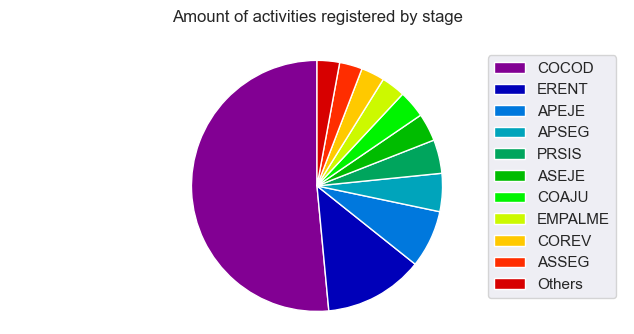

In [7]:
#count each stage occurance
counts = data["CODIGO_ETAPA"].value_counts().sort_values(ascending=False)
#print(counts.shape[0])
top_ten_counts = counts[:10]
below_top_ten_count = counts[10:]
Number_of_colors=11
plt.rcParams["figure.figsize"] = [6.50, 3.50]
plt.rcParams["figure.autolayout"] = True
palette = sns.color_palette('nipy_spectral',Number_of_colors)
others = pd.Series({"Others": below_top_ten_count[0].cumsum()[0]})
top_ten_and_others = top_ten_counts.append(others)
#print(top_ten_and_others)
# top_ten_counts_by_stage = top_ten_counts.groupby(["CODIGO_ETAPA"])
# print(top_ten_counts_by_stage)
#plt.pie( x=top_ten_and_others, labels=top_ten_and_others.keys(),colors=palette)
patches, texts = plt.pie(top_ten_and_others, colors=palette, startangle=90)
plt.legend(patches, top_ten_and_others.keys(), loc="best")
plt.title('Amount of activities registered by stage\n')
plt.axis('equal') 
plt.tight_layout()
plt.show()

## Stages with most hours invested

C:\Users\dtoloza\AppData\Local\Temp\ipykernel_15436\2384072404.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_ten_hours_and_others = top_ten_hours_count.append(others_hours)


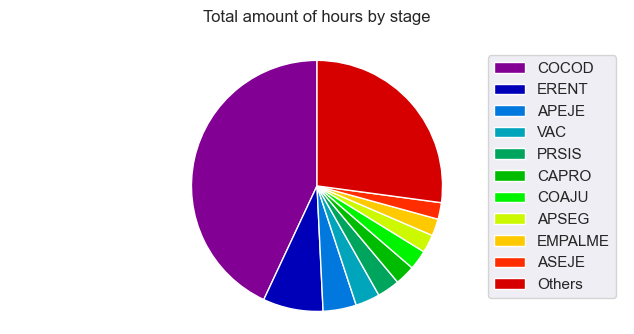

In [8]:
hours_count = data.groupby("CODIGO_ETAPA")["DURACION_HORAS"].sum().sort_values(ascending=False)
# print(hours_count)
plt.rcParams["figure.figsize"] = [6.50, 3.50]
plt.rcParams["figure.autolayout"] = True
top_ten_hours_count = hours_count[:10]
others_hours = pd.Series({"Others":hours_count[10:].sum(0)})
top_ten_hours_and_others = top_ten_hours_count.append(others_hours)
#plt.pie( x=top_ten_hours_and_others, labels=top_ten_hours_and_others.keys(),colors=palette)
patches, texts = plt.pie(top_ten_hours_and_others, colors=palette, startangle=90)
plt.legend(patches, top_ten_hours_and_others.keys(), loc="best")
plt.title('Total amount of hours by stage\n')
plt.axis('equal') 
plt.show()

In [9]:
plt.rcParams.update(plt.rcParamsDefault) #to set plot sizes to default
sns.set()
def get_chosen_stages()->list:
    chosen_stages:list  = top_ten_counts.keys().tolist()#data["CODIGO_ETAPA"].unique()
    return chosen_stages
get_chosen_stages()

row_condition = data["CODIGO_ETAPA"].isin(get_chosen_stages())
data = data[row_condition]
#data =data["CODIGO_ETAPA"==]
num_val_samples = int(data.shape[0] * 0.2)
train_data, test_data = train_test_split(data, test_size=num_val_samples, shuffle=True, random_state=6)
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

test_data

,DESCRIPCION,CODIGO_ETAPA,DURACION_HORAS
47751,Se siguio trabajando en los ajustes del metodo...,COCOD,2.00
49896,"Agregar campo a tabla y reporte, ajuste respon...",COCOD,2.25
43311,Daily ASW,APSEG,0.25
32612,REvision caso de uso Emit retry,COCOD,2.83
8749,Realizar estimacion de CO_1024_ANT_Estimacion ...,ASEJE,1.50
...,...,...,...
3841,Ajuste rechazos de los meses de junio y julio ...,APEJE,3.00
37052,"Sesion de avance diario, gestion del proyecto.",APEJE,3.00
10178,Ajuste modal vehiculos #207267,COCOD,1.00
18129,Daily Tecnico Clausula Penal con el grupo de S...,ERENT,0.50


# Model Creation for Stage Prediction

## Strings operations

In [10]:

def get_number_of_characters(s: str)->int:
    return len(s.replace(" ", ""))

def get_character_index(s: str)->int:
    all_characters: list = get_all_characters()
    index = all_characters.index(s)
    return index

## Biagram

In [29]:
# create matrix with biagram
def create_biagram() -> np.array:
    """
    @return a matrix filled with zeroes of size n_char x n_char
    """
    # The only characters we are going to consider.
    all_characters: list = get_all_characters()
    n_characters = len(all_characters)
    # create the matrix of size n_characters
    biagram: np.array = np.zeros((n_characters, n_characters))
    return biagram


def get_stage_descriptions(df: pd.DataFrame, stage: str) -> pd.DataFrame:
    """
    @input
        df: Dataframe with all the information.
        stage: stage to extract
    @return list with all the descriptions of the given stage
    """
    column_name: str = "CODIGO_ETAPA"
    mask = df[column_name] == stage
    return df[mask]["DESCRIPCION"]


def get_character_count(descriptions: pd.DataFrame) -> dict:
    """
    @input description: df with all the description of a stage.
    @return dictionary with character count of all the descriptions in a stage. 
    """
    all_characters = get_all_characters()
    character_count: dict = {}
    for description in descriptions:
        for character in all_characters:
            character_count[character] = description.count(character)
    return character_count


def get_filled_biagram(descriptions: pd.DataFrame) -> np.array:
    """
    @input list of all the descriptions for a stage
    @return matrix with character count, and the count of the next character
    """
    # create the matrix of size n_characters
    biagram: np.array = create_biagram()
    for description in descriptions:
        for index in range(0, len(description) - 1):
            # check current and next character
            current_character = description[index]
            current_character_index = get_character_index(current_character)

            next_character = description[index + 1]
            next_character_index = get_character_index(next_character)

            current_biagram_value = biagram[current_character_index][
                next_character_index
            ]
            biagram[current_character_index][next_character_index] = (
                current_biagram_value + 1
            )
    return biagram


## Probability Matrix

In [12]:
def normalize_probabilities(character_count: int, total_characters: int)->float:
    return character_count/total_characters

def get_marginal_probabilities(character_count: dict, text:str)->np.array:
    """
    @input 
        character_count: Dictionary with occurences of each character
        text: the text to analyse
    """
    character_probabilities = np.zeros(len(string.ascii_lowercase))
    n_characters = get_number_of_characters(text)
    for char in character_count.keys():
        index = list(character_count.keys()).index(char)
        character_probabilities[index] = normalize_probabilities(character_count[char], n_characters)+0.00001
    return character_probabilities

def get_cond_probabilities(joint_probability: np.array,marginal_probability: np.array)->np.array:
    conditional_probability = (joint_probability.T/marginal_probability).T
    # normalized matrix
    conditional_probability = conditional_probability/conditional_probability.sum() 
    prob_sum = conditional_probability.sum()
    print(f"prob_sum = {prob_sum}")
    return conditional_probability

def get_joint_probabilities(characters_count: np.array)->np.array:
    all_characters = get_all_characters()
    # + len(all_characters) to account for repetitions (aa, bb, cc, dd, etc.)
    n_pairs = characters_count.sum()
    joint_probability_matrix = create_biagram()
    prob_sum = 0
    for i, row in enumerate(characters_count):
        for j,count in enumerate(characters_count):
            joint_probability_matrix[i][j] = normalize_probabilities(characters_count[i][j], n_pairs)
            prob_sum = prob_sum + joint_probability_matrix[i][j]
    print(f"prob_sum = {prob_sum}")
    return joint_probability_matrix

In [13]:
def graph_matrix_heatmap(matrix: np.array, title="Heatmap"):
    all_characters = get_all_characters()
    # fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(matrix, cmap="Blues" ,annot=False, xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.xticks(rotation=0)
    plt.show()

## Model Creation

In [14]:
def language_identifier(text:str, matrix_probabilities: np.array)-> str:

    chosen_stages = get_chosen_stages()
    probs = np.zeros(10)
    clean_text = get_clean_text(text)
    for index in range(0, len(clean_text)-1):
      current_character = clean_text[index]
      next_character = clean_text[index+1]
      
      current_character_index = get_character_index(current_character)
      next_character_index = get_character_index(next_character)

      prob_vector: np.array = np.zeros((10))
      for idx in range(0,10):
        prob_vector[idx] = matrix_probabilities[idx][current_character_index][next_character_index]

      probs = probs + np.log(prob_vector+0.0000001)
    highest_prob_index = np.argmax(probs)
    three_highest = np.argpartition(probs, -3)[-3:]
    res  = chosen_stages[highest_prob_index]
    top3 = []
    top3.append(chosen_stages[three_highest[0]])
    top3.append(chosen_stages[three_highest[1]])
    top3.append(chosen_stages[three_highest[2]])
    return [res,top3]

# Model implementation for Stage prediction

## COCOD

### Descriptions

In [15]:

cocod_descriptions = get_stage_descriptions(train_data, "COCOD")
print(cocod_descriptions.head(10))

11430    Se trabaja en el proyecto 998, en el entregabl...
17775              Configurar reporte Multiples Documentos
14137                                                Daily
33249             Construccion en el modulo de comunicados
35043           PBI1129478: Se modifica la etl de tarjetas
24891                     Construccion diagramas de clases
49755                                    Ajuste paginacion
36302    Reunion con el equipo para revisar el servicio...
34850    Task 208762: Construir el archivo de salida po...
22400    211671 TK_SOPORTE_ASA_Synergia\nsoporte servic...
Name: DESCRIPCION, dtype: object


### Random Testing

In [16]:

def get_all_probability_matrices():
    all_characters = get_all_characters()
    probality_cube:np.array = np.zeros((10,len(all_characters),len(all_characters)))
    for index, stage in enumerate(get_chosen_stages()):
        stage_descriptions = get_stage_descriptions(train_data,stage)
        STAGE_dist = get_filled_biagram(stage_descriptions)
        STAGE_dist = get_joint_probabilities(STAGE_dist)
        probality_cube[index] = STAGE_dist
    return probality_cube
p_cube = get_all_probability_matrices()

prob_sum = 1.000000000000012
prob_sum = 1.0000000000000087
prob_sum = 0.9999999999999907
prob_sum = 0.999999999999993
prob_sum = 0.9999999999999928
prob_sum = 1.0000000000000058
prob_sum = 0.9999999999999918
prob_sum = 1.0000000000000002
prob_sum = 0.9999999999999878
prob_sum = 0.9999999999999863


# Testing

In [17]:
def get_stage_index(stage: str)->int:
    all_stages = get_chosen_stages()
    return all_stages.index(stage)

#It's test day!
fails: np.array        = np.zeros((10))
successes: np.array    = np.zeros((10))
three_option_fails     = np.zeros((10))
three_option_successes = np.zeros((10))
confusion_matrix       = np.zeros((10,10))
prob_cube = get_all_probability_matrices()

for row in test_data.iterrows():

    desc = row[1]["DESCRIPCION"]
    real_stage = row[1]["CODIGO_ETAPA"]
    pred = language_identifier(desc ,prob_cube)
    idx = get_stage_index(real_stage)
    pred_idx = get_stage_index(pred[0])
    confusion_matrix[pred_idx,idx] += 1
    if not (pred[0] == real_stage):
        fails[idx] = fails[idx] + 1
    else:
        successes[idx] = successes[idx] + 1
    if not (real_stage in pred[1]):
        three_option_fails[idx] += 1
    else:
        three_option_successes[idx] += 1
    

prob_sum = 1.000000000000012
prob_sum = 1.0000000000000087
prob_sum = 0.9999999999999907
prob_sum = 0.999999999999993
prob_sum = 0.9999999999999928
prob_sum = 1.0000000000000058
prob_sum = 0.9999999999999918
prob_sum = 1.0000000000000002
prob_sum = 0.9999999999999878
prob_sum = 0.9999999999999863


# Results

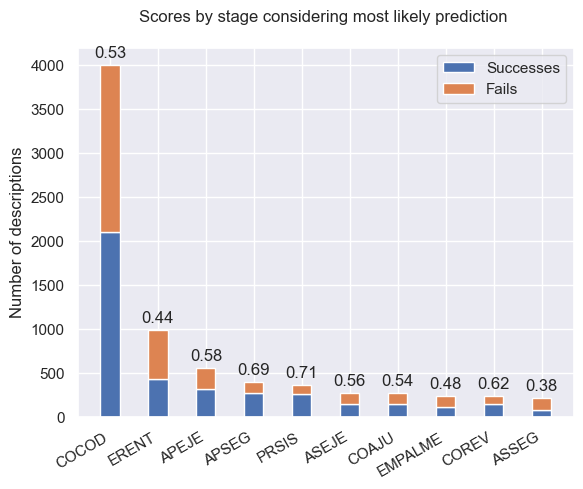

Fails     = 3507.0
Successes = 4046.0
Accuracy  = 0.535681186283596


In [18]:
labels = get_chosen_stages()
width = 0.4       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

successes_bar = ax.bar(labels, successes, width, label='Successes')
fails_bar     = ax.bar(labels, fails, width, bottom=successes, label='Fails')
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('Number of descriptions')
ax.set_title('Scores by stage considering most likely prediction \n')
ax.legend()

def autolabel(rects,baserects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for i in range(0,len(rects)):
        height = rects[i].get_height()
        base_height = baserects[i].get_height()
        ax.annotate('{0:.2g}'.format(base_height/(height+base_height)),
                    xy=(rects[i].get_x() + rects[i].get_width() / 2, height+base_height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(fails_bar,successes_bar)
plt.show()
fails_sum = fails.sum()
successes_sum = successes.sum()
print(f"Fails     = {fails_sum}")
print(f"Successes = {successes_sum}")
print(f"Accuracy  = {successes_sum/(successes_sum+fails_sum)}")

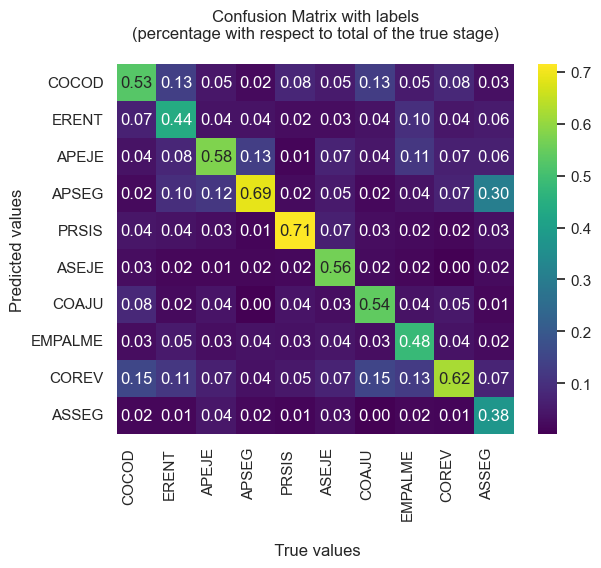

In [19]:
confusion_percent= confusion_matrix/confusion_matrix.sum(axis=0)

ax = sns.heatmap(confusion_percent, annot=True, cmap="viridis",fmt='0.2f')

ax.set_title('Confusion Matrix with labels\n(percentage with respect to total of the true stage)\n');
ax.set_xlabel('\n True values')
ax.set_ylabel('Predicted values');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(get_chosen_stages())
ax.yaxis.set_ticklabels(get_chosen_stages())
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0, ha='right')

## Display the visualization of the Confusion Matrix.
plt.show()

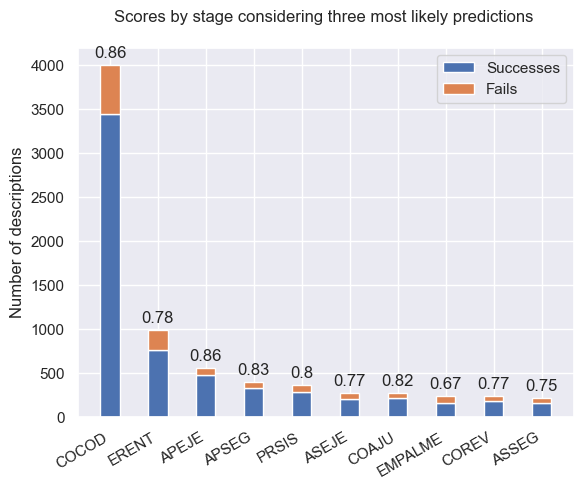

Fails     = 1305.0
Successes = 6248.0
Accuracy  = 0.827220971799285


In [20]:
labels = get_chosen_stages()
width = 0.4       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

successes_bar = ax.bar(labels, three_option_successes, width, label='Successes')
fails_bar     = ax.bar(labels,  three_option_fails, width, bottom=three_option_successes, label='Fails')
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('Number of descriptions')
ax.set_title('Scores by stage considering three most likely predictions \n')
ax.legend()

def autolabel(rects,baserects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for i in range(0,len(rects)):
        height = rects[i].get_height()
        base_height = baserects[i].get_height()
        ax.annotate('{0:.2g}'.format(base_height/(height+base_height)),
                    xy=(rects[i].get_x() + rects[i].get_width() / 2, height+base_height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(fails_bar,successes_bar)
plt.show()
fails_sum =  three_option_fails.sum()
successes_sum =  three_option_successes.sum()
print(f"Fails     = {fails_sum}")
print(f"Successes = {successes_sum}")
print(f"Accuracy  = {successes_sum/(successes_sum+fails_sum)}")

# Model Creation for Duration Prediction

## Data Exploration

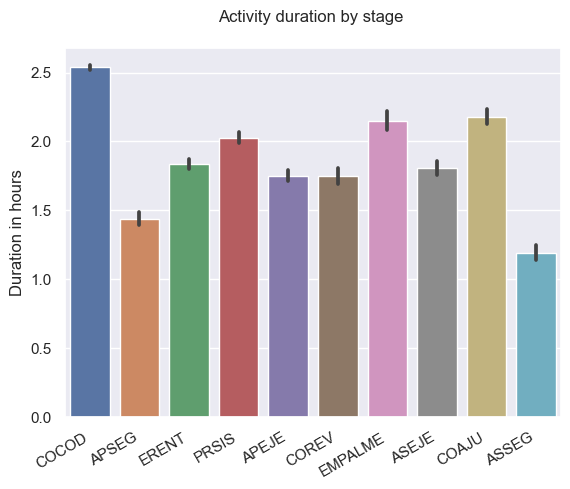

In [21]:
sns.barplot(x=data["CODIGO_ETAPA"], y=data["DURACION_HORAS"], data=data)
plt.xticks(rotation=30, ha='right')
plt.title('Activity duration by stage \n')
plt.xlabel(None)
plt.ylabel('Duration in hours')
plt.show()

## Model Implementation for duration prediction

In [22]:
def minus_gamma_log_likelihood (par,x):
    """
    Que tan probable es que cierta gama con ciertos datos se ajuste a los los datos que tienes
    @input: 
        par: parametros de la gamma (o la gama en si porque los parametros definen a la gamma)
        x: datos
    """
    alpha, lam = par
    n =len(x)
    #minimizar la menos verosimilitud = max la verosimilitud
    #print(abs(math.gamma(alpha))+0.0001)
    like = -(n*alpha*np.log(lam)-lam*np.sum(x)+(alpha-1)*np.sum(np.log(x))-n*np.log(math.gamma(alpha)))
    return like

def gamma_estimator(x: np.array):
    """
    Encontrar la gamma mas probable para los datos
    @input: datos 
    """
    #x = [2,2,1,3,2,...]
    first_lambd = np.mean(x)/np.var(x)
    first_alpha = first_lambd*np.mean(x)
    first_guess = [first_alpha,first_lambd]
    sol = op.minimize(minus_gamma_log_likelihood, first_guess , args=(x),method='Nelder-Mead',bounds=[(0.01,1000),(0.01,1000)])
    par_optimos = sol.x
    # print(sol)
    return par_optimos

In [23]:
#[2,2,1,8,]
COCOD_hours = np.array(data['COCOD'==data["CODIGO_ETAPA"]]['DURACION_HORAS'])
prueba=gamma_estimator(COCOD_hours)
print(prueba)

[4.23705411 1.6700252 ]


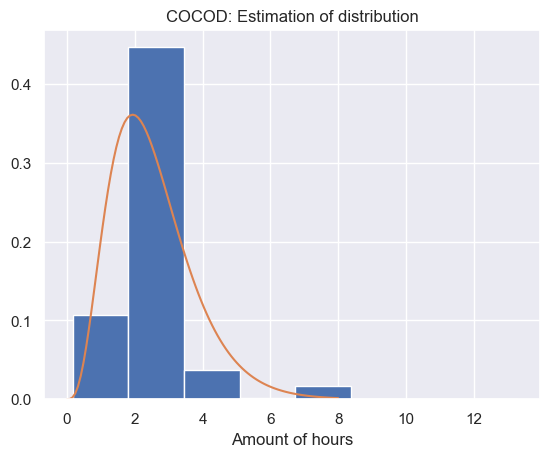

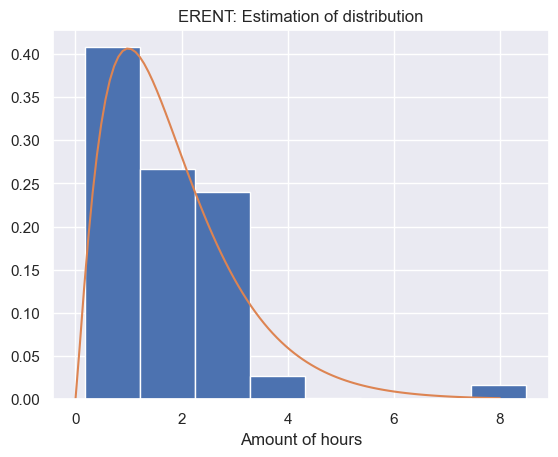

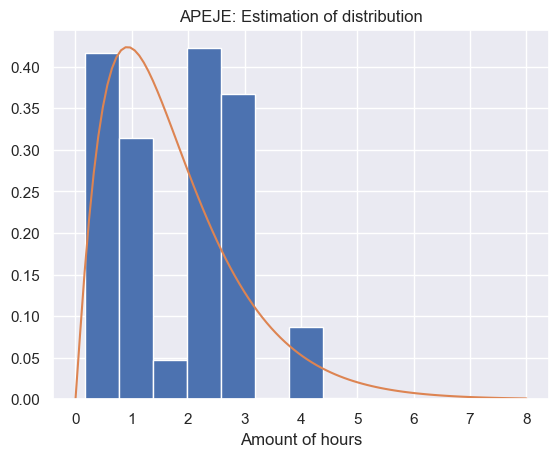

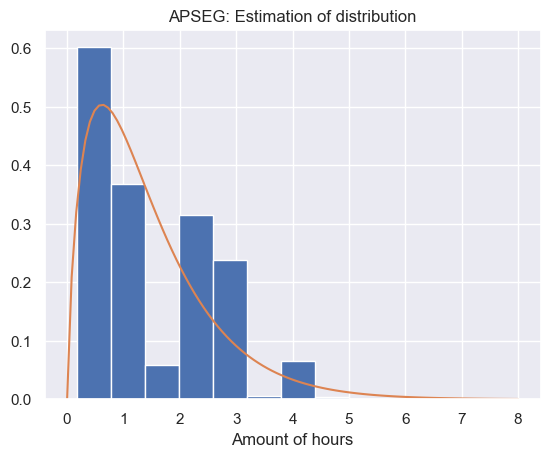

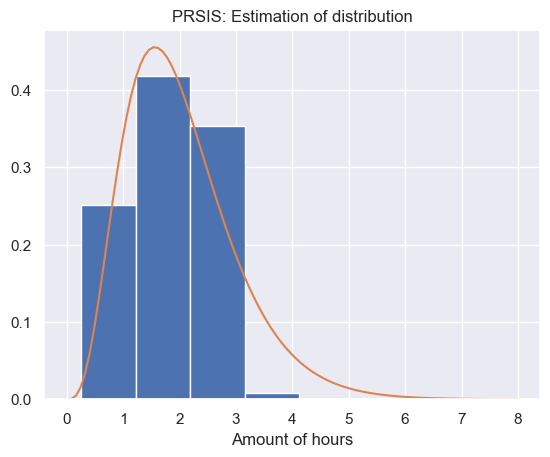

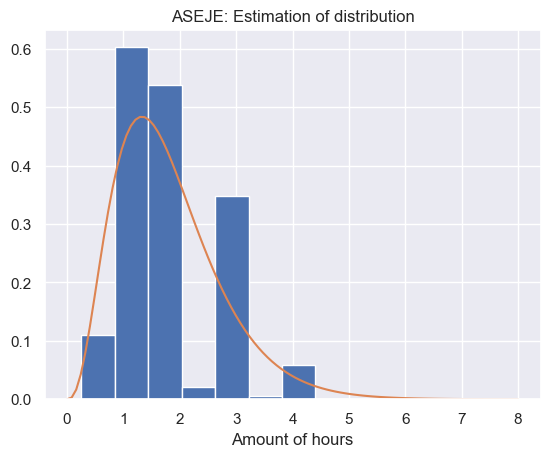

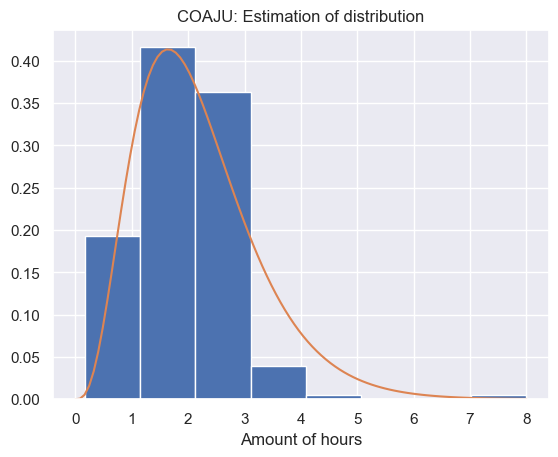

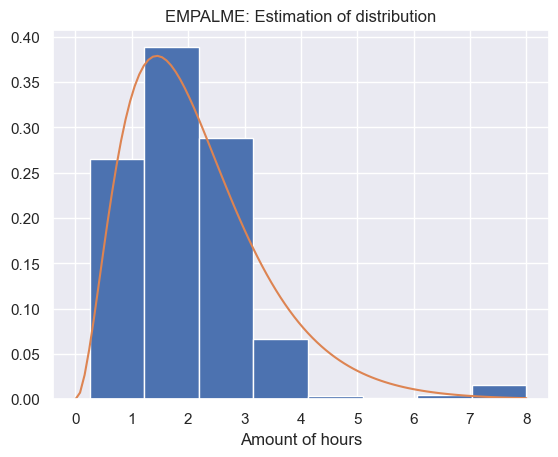

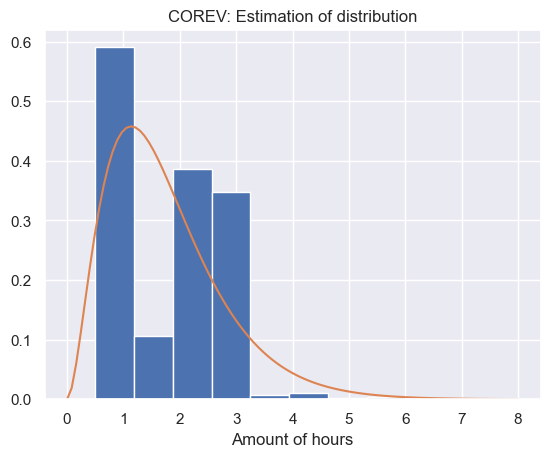

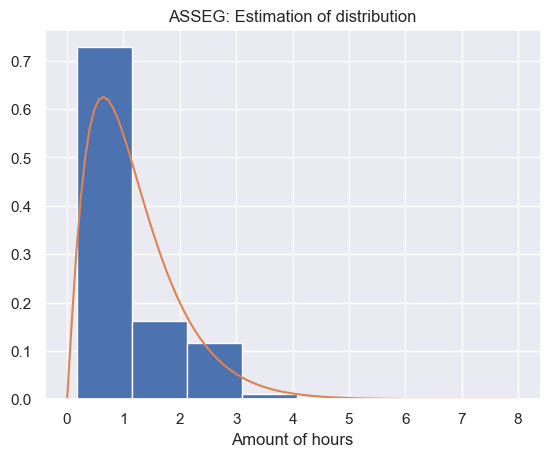

In [24]:
def plot_distribution():

    for stage in get_chosen_stages():

        x = np.linspace (0, 8, 100) 
        stage_data = np.array(data[stage==data["CODIGO_ETAPA"]]['DURACION_HORAS'])
        #calculate pdf of Gamma distribution for each x-value
        alpha, lambd = gamma_estimator(stage_data)
        y = stats.gamma.pdf(x, a=alpha, scale=1/lambd)

        #create plot of Gamma distribution
        # density normaliza
        plt.hist(stage_data,density = True,bins=8)
        plt.plot(x,y)
        plt.title(f'{stage}: Estimation of distribution')
        plt.xlabel('Amount of hours')
        plt.show()
plot_distribution()

In [25]:
def get_params()->dict:
    params:dict  = {}
    for stage in get_chosen_stages():
        stage_hours = np.array(data[stage==data["CODIGO_ETAPA"]]['DURACION_HORAS'])
        #Saca un np.array con las horas de stage [2,2,3,1,2,...]
        alpha, lambd = gamma_estimator(stage_hours)
        params[stage] = np.array([alpha, lambd])
    return params

stage_params = get_params()
print(stage_params)

def calcular_prob(stage, x1, x2):
    alpha, lambd = get_params()[stage]
    probability = stats.gamma.cdf(x2,a=alpha,scale=1/lambd)-stats.gamma.cdf(x1,a=alpha,scale=1/lambd)
    #Ok, calcula la probabilidad de que x1<x<x2 en una gama con parametros [4.50616811 1.80051312]
    return probability

{'COCOD': array([4.23705411, 1.6700252 ]), 'ERENT': array([2.17953407, 1.18500535]), 'APEJE': array([2.11228726, 1.20487584]), 'APSEG': array([1.75331194, 1.21689398]), 'PRSIS': array([4.32272345, 2.13269803]), 'ASEJE': array([3.7497564 , 2.07202713]), 'COAJU': array([4.07025718, 1.86723125]), 'EMPALME': array([3.03744926, 1.41225382]), 'COREV': array([2.86051494, 1.63696078]), 'ASSEG': array([2.16019242, 1.81126525])}


In [26]:
calcular_prob('ASEJE',0,3.0)

0.8914036058736663

## Comparison between distributions

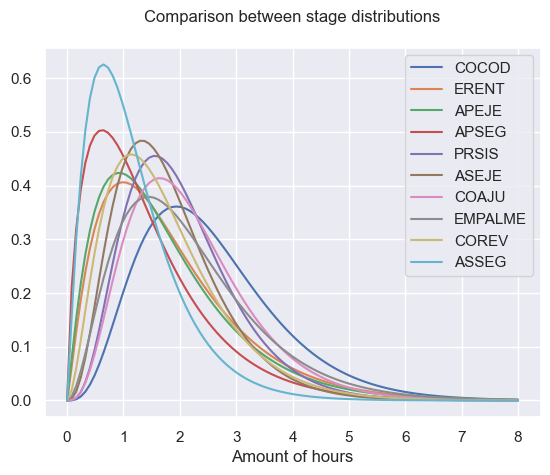

In [27]:
x = np.linspace (0, 8, 100) 
for stage in get_chosen_stages():
    stage_data = np.array(data[stage==data["CODIGO_ETAPA"]]['DURACION_HORAS'])
    #calculate pdf of Gamma distribution for each x-value
    alpha, lambd = stage_params[stage]
    y = stats.gamma.pdf(x, a=alpha, scale=1/lambd)
    plt.plot(x,y, label=stage)
plt.title('Comparison between stage distributions\n')
plt.xlabel('Amount of hours')
plt.legend()
plt.show()

# Unit Tests

In [ ]:
class TestModel(unittest.TestCase):
    """
    @classmethod#SE EJECUTA UNA VEZ ANTES DE TODOS LOS TEST
    def setUpClass(cls) -> None:
        print('setUpClass')
    
    @classmethod#SE EJECUTA DESPUES DE LA EJECUCION DE TODOS LOS TEST
    def tearDownClass(cls) -> None:
        print('tearDownClass')

    def setUp(self):#Sirve para guardar variables y usarlas en todos los test
        #self.variabledf = df(con alguna vaina) 
        pass#para usarlo tiene que ponerse self. siempre

    def tearDown(self):#Add files to a directory or to a database- you create them in the setUp and tearDown is there to delete them
        pass
    """
    #Data Cleaning Functions
    def test_get_all_characters()-> list:
        pass

    def test_get_all_stages(df: pd.DataFrame):
        pass

    def test_get_relevant_columns_names()-> list:
        pass
    
    def test_get_clean_text(text: str) -> str:
        pass

    def test_get_relevant_columns(df: pd.DataFrame):
        pass

    #Model Creation for Stage prediction functions
    #String operations
    def test_get_number_of_characters(s: str)->int:
        pass

    def get_character_index(s: str)->int:
        pass

    ##Biagram
    def test_create_biagram() -> np.array:
        pass

    def test_get_stage_descriptions(df: pd.DataFrame, stage: str) -> pd.DataFrame:
        pass
    
    def test_get_character_count(descriptions: pd.DataFrame) -> dict:
        pass

    def test_get_filled_biagram(descriptions: pd.DataFrame) -> np.array:
        pass

    ##Probability Matrix functions
    def test_normalize_probabilities(character_count: int, total_characters: int)->float:
        pass

    def test_get_marginal_probabilities(character_count: dict, text:str)->np.array:
        pass

    def test_get_cond_probabilities(joint_probability: np.array,marginal_probability: np.array)->np.array:
        pass

    def test_get_joint_probabilities(characters_count: np.array)->np.array:
        pass

    def test_graph_matrix_heatmap(matrix: np.array, title="Heatmap"):
        pass

    #Model creation
    def test_language_identifier(text:str, matrix_probabilities: np.array)-> str:
        pass

    #Model implementation for Stage prediction
    #Random Testing --
    def test_get_all_probability_matrices():
        pass

    #Testing --
    def test_get_stage_index(stage: str)->int:
        pass

    #Model Creation for Duration Prediction
    #Model Implementation for duration prediction
    def test_minus_gamma_log_likelihood (par,x):
        pass
    def test_gamma_estimator(x: np.array):
        pass

    #Omití las funciones plot_distribution() y autolabel(rects,baserects) por no ser relevantes

    def test_get_params()->dict:
        pass
    
    def test_calcular_prob(stage, x1, x2):
        pass

unittest.main(argv=[''], verbosity=2, exit=False)